In [1]:
# Read league of legends data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 108
pd.options.display.max_columns = None
league = pd.read_csv('../data/league-of-legends/high_diamond_ranked_10min.csv')

In [2]:
# Get Pandas Profiling Report
from pandas_profiling import ProfileReport
ProfileReport(league, minimal=True).to_notebook_iframe()

In [3]:
from sklearn.model_selection import train_test_split

def wrangle(X, target):
    """Wrangle train, validate, and test sets in the same way"""

    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # Dropping 'gameId' column due to being unrelated to the outcome of the match
    dropped = ['gameId']
    
    # 'redFirstBlood' is redundant since it will always be the opposite of blueFirstBlood
    dropped.append('redFirstBlood')

    # 'blueDeaths' and 'redDeaths' are redundant since they are the same as 'redKills' and 'blueKills'
    dropped.append('redDeaths')
    dropped.append('blueDeaths')
    
    # 'blueGoldPerMin' and 'redGoldPerMin' are redundant since they are the same as 'blueTotalGold'
    # and 'redTotalGold' divided by 10
    dropped.append('blueGoldPerMin')
    dropped.append('redGoldPerMin')
    
    # 'blueCSPerMin' and 'redCSPerMin' are redundant since they are the same as
    # 'blueTotalMinionsKilled' and 'redblueTotalMinionsKilled' divided by 10
    dropped.append('blueCSPerMin')
    dropped.append('redCSPerMin')
    
    # 'redGoldDiff' is redundant since it will always be the negative of 'blueGoldDiff'
    dropped.append('redGoldDiff')
    
    # 'redExperienceDiff' is redundant since it will always be the negative of 'blueExperienceDiff'
    dropped.append('redExperienceDiff')
    
    # features that are importance mean of less than or equal to zero
    dropped.append('blueAvgLevel')
    dropped.append('redAvgLevel')
    dropped.append('blueWardsDestroyed')
    dropped.append('redWardsDestroyed')
    dropped.append('blueAssists')
    dropped.append('redAssists')
    
    X.drop(columns=dropped, inplace=True)
    
    # Split df into train & test. 80/20 split.
    train, test = train_test_split(X, test_size=0.20,
                               stratify=X[target], random_state=42)

    # Split train into train & val. 80/20 split.
    train, val = train_test_split(train, test_size=0.20,
                               stratify=train[target], random_state=42)
    
    # return the wrangled dataframe
    return train, val, test

In [4]:
# Setting target to blueWins
target = 'blueWins'
train, val, test = wrangle(league, target)

In [5]:
# Arrange data into X features matrix and y target vector
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test.drop(columns=target)
y_test = test[target]

In [6]:
# converting target into a list to find the majority class
# using value_counts(normalize=True) to find the accuracy score
y = y_train.values.tolist()
majority_class = max(set(y), key = y.count)
print(f'Majority Class: {majority_class}')
print(f'Accuracy Score: {y_train.value_counts(normalize=True)[0]:,.2f}')

Majority Class: 0
Accuracy Score: 0.50


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import GridSearchCV

# Instantiate model
log = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LogisticRegression())
])

param_grid = [
    {
    'lr__penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'lr__C' : np.logspace(-4, 4, 20),
    'lr__solver' : ['lbfgs', 'newton-cg', 'liblinear', 'sag' ,'saga'],
    'lr__max_iter' : [100, 1000, 2500, 5000]
    }
]

lr = GridSearchCV(log, param_grid = param_grid, cv = 3, verbose = True, n_jobs = -1)

In [8]:
# Fit model on training data
best_lr = lr.fit(X_train, y_train)

Fitting 3 folds for each of 1600 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1132 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 2904 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 3976 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 4789 out of 4800 | elapsed:   48.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:   48.1s finished


In [9]:
# Check performance metric (accuracy) on train, validation, and test sets
print('Training Accuracy:', best_lr.score(X_train, y_train))
print('Validating Accuracy:', best_lr.score(X_val, y_val))

Training Accuracy: 0.7396393546346093
Validating Accuracy: 0.7280202403542062


In [10]:
best_lr.best_estimator_

Pipeline(steps=[('ss', StandardScaler()),
                ('lr',
                 LogisticRegression(C=0.03359818286283781, max_iter=2500,
                                    penalty='l1', solver='liblinear'))])

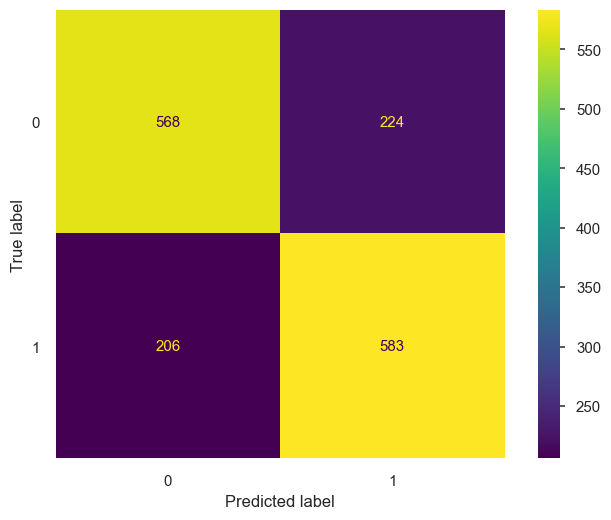

In [11]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(best_lr, X_val, y_val, values_format='.0f')

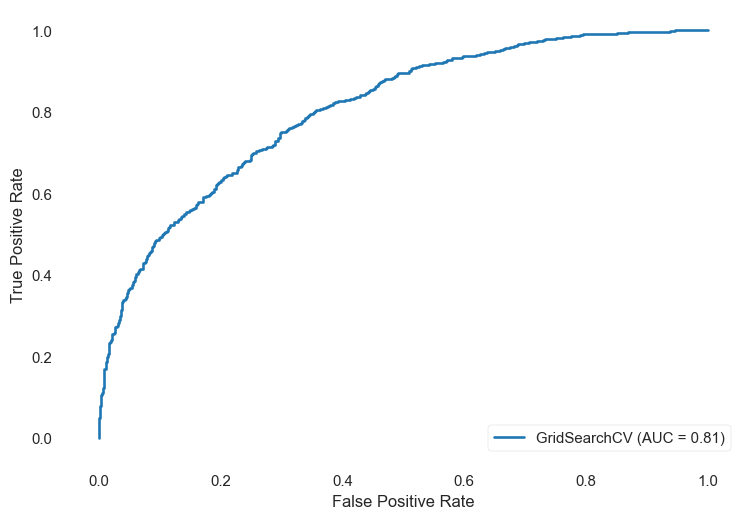

In [12]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(best_lr, X_test, y_test)

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.model_selection import GridSearchCV

# Instantiate model
rf = Pipeline([
    ('ss', StandardScaler()),
    ('rfc', RandomForestClassifier())
])

param_grid = [
    {
    'rfc__n_estimators' : [100, 1000, 2500, 5000],
    'rfc__max_features' : ['auto', 'sqrt', 'log2'],
    }
]

rfc = GridSearchCV(rf, param_grid = param_grid, cv = 3, verbose = True, n_jobs = -1)

In [14]:
# Fit model on training data
best_rfc = rfc.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.9min finished


In [15]:
# Check performance metric (accuracy) on train, validation, and test sets
print('Training Accuracy:', best_rfc.score(X_train, y_train))
print('Validating Accuracy:', best_rfc.score(X_val, y_val))

Training Accuracy: 1.0
Validating Accuracy: 0.7197975964579381


In [16]:
best_rfc.best_estimator_

Pipeline(steps=[('ss', StandardScaler()),
                ('rfc',
                 RandomForestClassifier(max_features='sqrt',
                                        n_estimators=2500))])

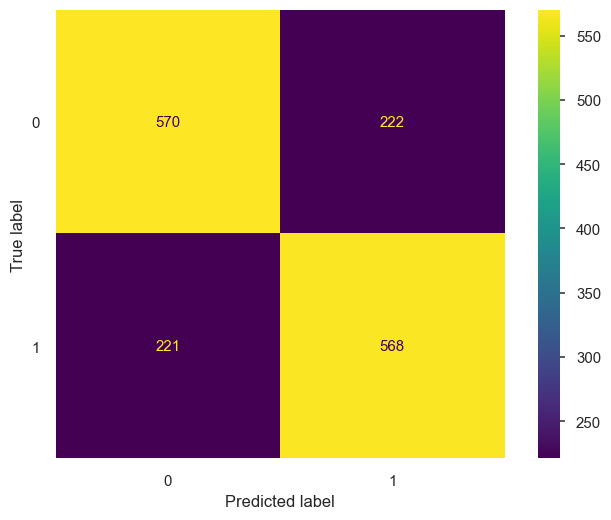

In [17]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(best_rfc, X_val, y_val, values_format='.0f')

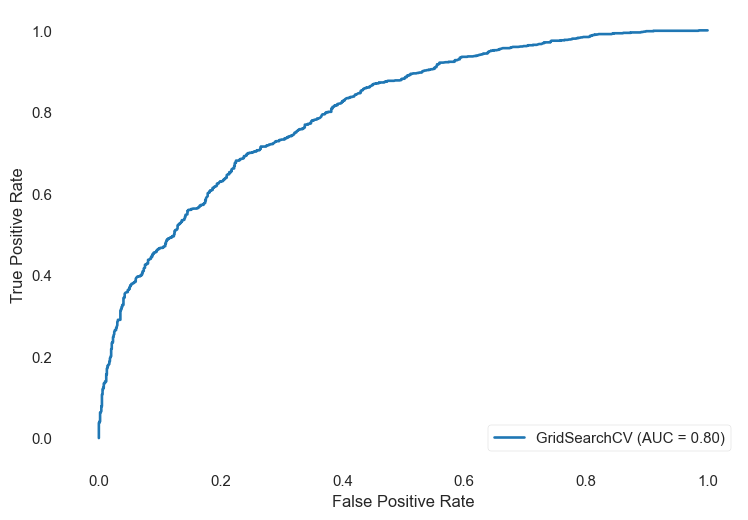

In [18]:
plot_roc_curve(best_rfc, X_test, y_test)

In [19]:
from sklearn.inspection import permutation_importance

result = permutation_importance(best_lr, X_val, y_val,
                                n_repeats=5, random_state=42)

df = pd.DataFrame({'feature': X_val.columns,
                  'importances_mean': np.round(result['importances_mean'], 3),
                  'importances_std': result['importances_std']})

df.sort_values(by='importances_mean', ascending=False)

,feature,importances_mean,importances_std
11,blueGoldDiff,0.139,0.009606
12,blueExperienceDiff,0.014,0.003333
16,redDragons,0.003,0.003225
4,blueDragons,0.002,0.002016
21,redTotalMinionsKilled,0.000,0.000000
19,redTotalGold,0.000,0.000000
17,redHeralds,0.000,0.000000
14,redKills,0.000,0.000000
13,redWardsPlaced,0.000,0.000000
22,redTotalJungleMinionsKilled,0.000,0.000000


In [20]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    best_lr,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)
permuter.fit(X_val, y_val)

eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_val.columns.tolist()
)

c:\users\xpand\.virtualenvs\ds-builds-hthgmlxs\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
c:\users\xpand\.virtualenvs\ds-builds-hthgmlxs\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight,Feature
0.1303 ± 0.0125,blueGoldDiff
0.0153 ± 0.0072,blueExperienceDiff
0.0025 ± 0.0032,redDragons
0.0005 ± 0.0023,blueTotalJungleMinionsKilled
0.0004 ± 0.0026,blueTotalGold
0.0004 ± 0.0015,redEliteMonsters
0.0003 ± 0.0019,redTowersDestroyed
0.0001 ± 0.0056,blueDragons
0 ± 0.0000,blueTotalMinionsKilled
0 ± 0.0000,blueKills


(<Figure size 810x1026 with 3 Axes>,
 {'title_ax': <AxesSubplot:>,
  'pdp_inter_ax': <AxesSubplot:xlabel='blueTotalGold', ylabel='blueGoldDiff'>})

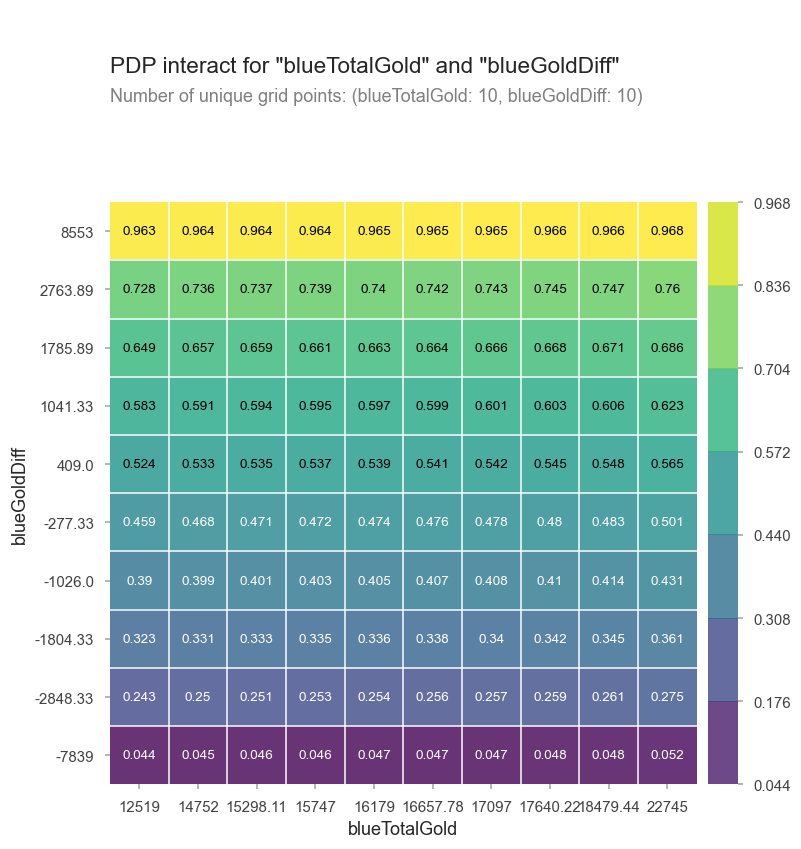

In [21]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['blueTotalGold', 'blueGoldDiff']

interaction = pdp_interact(
    model=best_lr,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features)

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import GridSearchCV

# Instantiate model
log = Pipeline([
    ('ss', StandardScaler()),
    ('clf', LogisticRegression())
])

features = ['blueTowersDestroyed', 'blueTotalGold', 'blueKills', 'redKills', 'redTotalGold', 'redTowersDestroyed', 'blueGoldDiff']

param_grid = [
    {
    'clf__penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'clf__C' : np.logspace(-4, 4, 20),
    'clf__solver' : ['lbfgs', 'newton-cg', 'liblinear', 'sag' ,'saga'],
    'clf__max_iter' : [100, 1000, 2500, 5000]
    }
]

clf = GridSearchCV(log, param_grid = param_grid, cv = 3, verbose = True, n_jobs = -1)

In [28]:
# Fit model on training data
best_clf = clf.fit(X_train[features], y_train)

Fitting 3 folds for each of 1600 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 2060 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 4500 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:   19.7s finished


In [29]:
# Check performance metric (accuracy) on train, validation, and test sets
print('Training Accuracy:', best_clf.score(X_train[features], y_train))
print('Validating Accuracy:', best_clf.score(X_val[features], y_val))
print('Testing Accuracy:', best_clf.score(X_test[features], y_test))

Training Accuracy: 0.725561531161025
Validating Accuracy: 0.7191650853889943
Testing Accuracy: 0.7196356275303644


In [30]:
best_rfc.best_estimator_

Pipeline(steps=[('ss', StandardScaler()),
                ('rfc',
                 RandomForestClassifier(max_features='sqrt',
                                        n_estimators=2500))])

In [25]:
from joblib import dump
dump(best_clf, 'pipeline.joblib', compress=True)

['pipeline.joblib']

In [26]:
import joblib
import sklearn
import numpy

print(f'joblib=={joblib.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'numpy=={numpy.__version__}')

joblib==0.16.0
scikit-learn==0.23.1
numpy==1.19.1
